1. Prepare data 
    * Open files, look into data
    * Calculate recovery feature by hand, check `rougher.output.recovery` feature
    * Analyze features not available in the test set
    * Data preprocessing
2. Analyze data
    * Concentrations of metals at different stages of purification
    * Feed particle size distributions in training and test sets
    * Total concentrations of all substances at different stages
3. Build model
    * Write function to calculate final sMAPE value
    * Train models, evaluate using cross-validation
    * Pick the best model, test using test sample
4. Conclusion
 

**Objective**

Build a machine learning model for [Zyfra](https://www.zyfra.com/) to optimize production of gold and eliminate unprofitable parameters. Final model will predict the amount of gold recovered from gold ore. 

# 1. Prepare data

**Open files, look into data**

In [66]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

In [5]:
train_df = pd.read_csv('/datasets/gold_recovery_train.csv')
train_df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [7]:
test_df = pd.read_csv('/datasets/gold_recovery_test.csv')
test_df.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [9]:
full_df = pd.read_csv('/datasets/gold_recovery_full.csv')
full_df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [10]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

In [11]:
train_df.duplicated().sum()

0

In [12]:
test_df.duplicated().sum()

0

**Calculate the recovery feature by hand, and check against `rougher.output.recovery` feature**

In [13]:
train_df['rougher.output.recovery'].describe()

count    14287.000000
mean        82.394201
std         15.096808
min          0.000000
25%         79.818372
50%         85.235997
75%         90.131691
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [14]:
# values for calculating the rougher concentrate recovery

C = train_df['rougher.output.concentrate_au'] # share of gold in concentrate, after flotation
F = train_df['rougher.input.feed_au'] # share of gold in feed, before flotation
T = train_df['rougher.output.tail_au'] # share of gold in rougher tails, after flotation

recovery_calc = ((C * (F - T)) / (F * (C - T))) * 100

In [15]:
pd.set_option('mode.use_inf_as_na', True)

recovery_calc.isna().sum()

2313

In [16]:
recovery_calc = recovery_calc.dropna()
recovery_calc = recovery_calc[(recovery_calc >= 0.0)]
recovery_calc.describe()

count    14411.000000
mean        85.206568
std        155.955847
min         -0.000000
25%         79.888241
50%         85.310848
75%         90.265816
max      13802.071756
dtype: float64

In [17]:
target = train_df['rougher.output.recovery']
target = target.dropna()

mae = mean_absolute_error(target, recovery_calc[target.index])
print(mae)

9.444891926100695e-15


To check that the recovery value is calculated correctly, I wrote a formula that used the related column values. Since there were infinite values in these columns, I set `mode.use_inf_as_na` to True, and then dropped them, along with negative values (which I presume are impossible), and NaN values. I could then compare the hand calculated recovery values to the raw data from the training dataset, as well as calculate the MAE. The resulting MAE is infinitesimally small, which indicates that the recovery column is indeed calculated correctly.

**Analyze parameters not in test set**

In [18]:
missing = np.setdiff1d(train_df.columns, test_df.columns)
print(missing)

['final.output.concentrate_ag' 'final.output.concentrate_au'
 'final.output.concentrate_pb' 'final.output.concentrate_sol'
 'final.output.recovery' 'final.output.tail_ag' 'final.output.tail_au'
 'final.output.tail_pb' 'final.output.tail_sol'
 'primary_cleaner.output.concentrate_ag'
 'primary_cleaner.output.concentrate_au'
 'primary_cleaner.output.concentrate_pb'
 'primary_cleaner.output.concentrate_sol' 'primary_cleaner.output.tail_ag'
 'primary_cleaner.output.tail_au' 'primary_cleaner.output.tail_pb'
 'primary_cleaner.output.tail_sol' 'rougher.calculation.au_pb_ratio'
 'rougher.calculation.floatbank10_sulfate_to_au_feed'
 'rougher.calculation.floatbank11_sulfate_to_au_feed'
 'rougher.calculation.sulfate_to_au_concentrate'
 'rougher.output.concentrate_ag' 'rougher.output.concentrate_au'
 'rougher.output.concentrate_pb' 'rougher.output.concentrate_sol'
 'rougher.output.recovery' 'rougher.output.tail_ag'
 'rougher.output.tail_au' 'rougher.output.tail_pb'
 'rougher.output.tail_sol' 'secon

The features that are missing in the test set are calculation characteristics of the flotation stage - gold to lead ratio, the sulphate reagent additions to floatbank 10 and 11, and the sulphate to gold concentrate. The test set still includes the actual amount of sulphate and lead input for floatboanks 10 and 11, as well as feed rate and size, so the data to make these calculations is present if these calculations are necessary.

**Data preprocessing**

In [19]:
train_df['date'] = pd.to_datetime(train_df['date'], format='%Y-%m-%d %H:%M:%S')
train_df['date'].dtypes

dtype('<M8[ns]')

In [20]:
test_df['date'] = pd.to_datetime(test_df['date'], format='%Y-%m-%d %H:%M:%S')
test_df['date'].dtypes

dtype('<M8[ns]')

In [21]:
full_df['date'] = pd.to_datetime(full_df['date'], format='%Y-%m-%d %H:%M:%S')
full_df['date'].dtypes

dtype('<M8[ns]')

In [22]:
train_is_nan = train_df.isna()
print(train_is_nan.any(axis=1).sum())

test_is_nan = test_df.isna()
print(test_is_nan.any(axis=1).sum())

full_is_nan = full_df.isna()
print(full_is_nan.any(axis=1).sum())

5843
473
6622


In [23]:
train_numerical = [col for col in train_df.columns if 'date' not in col]

for col in train_numerical:
    train_df[col] = train_df[col].replace(np.nan, train_df[col].mean())
    
test_numerical = [col for col in test_df.columns if 'date' not in col]

for col in test_numerical:
    test_df[col] = test_df[col].replace(np.nan, test_df[col].mean())

In [24]:
train_df = train_df.drop(['rougher.calculation.au_pb_ratio',
                                'rougher.calculation.floatbank10_sulfate_to_au_feed',
                                'rougher.calculation.floatbank11_sulfate_to_au_feed',
                                'rougher.calculation.sulfate_to_au_concentrate'], axis=1)

For preprocessing, I first changed the datatype of the `date` column to datetime, so that it would be easier to work with later on. I also found the rest of the NaN values, and counted them. Since there were so many (~30% of the training and full datasets, closer to 10% for the test dataset), I decided to fill them with mean values for the column instead of eliminating the rows with NA values altogether. Finally, I removed the `rougher.calculation` features from the training set features, since the test set wouldn't have them.

# 2. Analyze the data

In [25]:
au_rougher_in = train_df['rougher.input.feed_au']
au_rougher_out = train_df['rougher.output.concentrate_au']
au_prim_out = train_df['primary_cleaner.output.concentrate_au'].values
au_final_out = train_df['final.output.concentrate_au'].values

ag_rougher_in = train_df['rougher.input.feed_ag']
ag_rougher_out = train_df['rougher.output.concentrate_ag'].values
ag_prim_out = train_df['primary_cleaner.output.concentrate_ag'].values
ag_final_out = train_df['final.output.concentrate_ag'].values

pb_rougher_in = train_df['rougher.input.feed_pb']
pb_rougher_out = train_df['rougher.output.concentrate_pb'].values
pb_prim_out = train_df['primary_cleaner.output.concentrate_pb'].values
pb_final_out = train_df['final.output.concentrate_pb'].values

Text(0, 0.5, 'Count (normalized)')

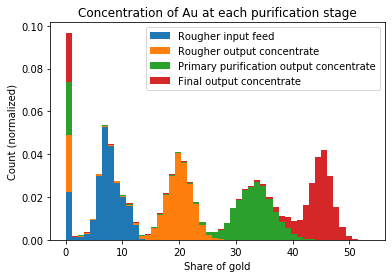

In [26]:
labels = ['Rougher input feed', 'Rougher output concentrate','Primary purification output concentrate', 
          'Final output concentrate']

au_data = [au_rougher_in, au_rougher_out, au_prim_out, au_final_out]

fig, ax = plt.subplots()

ax.hist(au_data, bins=50, density=True, histtype='bar', stacked=True, label=labels)
ax.legend()
ax.set_title('Concentration of Au at each purification stage')
ax.set_xlabel('Share of gold')
ax.set_ylabel('Count (normalized)')

Text(0, 0.5, 'Count (normalized)')

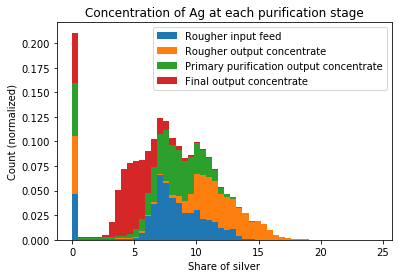

In [27]:
ag_data = [ag_rougher_in, ag_rougher_out, ag_prim_out, ag_final_out]

fig, ax = plt.subplots()

ax.hist(ag_data, bins=50, density=True, histtype='bar', stacked=True, label=labels)
ax.legend()
ax.set_title('Concentration of Ag at each purification stage')
ax.set_xlabel('Share of silver')
ax.set_ylabel('Count (normalized)')

Text(0, 0.5, 'Count (normalized)')

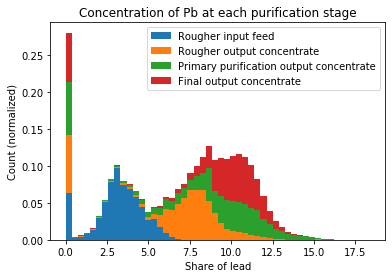

In [28]:
pb_data = [pb_rougher_in, pb_rougher_out, pb_prim_out, pb_final_out]

fig, ax = plt.subplots()

ax.hist(pb_data, bins=50, density=True, histtype='bar', stacked=True, label=labels)
ax.legend()
ax.set_title('Concentration of Pb at each purification stage')
ax.set_xlabel('Share of lead')
ax.set_ylabel('Count (normalized)')

To examine how the concentrations of each metal change at the individual stages of purification, I used stacked histograms. I appears that concentrations of gold increase at each stage, concentrations of silver reduce, and lead stays more consistent. 

**Check feed particle size**

In [29]:
print(train_df['rougher.input.feed_size'].describe())
print(test_df['rougher.input.feed_size'].describe())

count    16860.000000
mean        58.676444
std         23.624881
min          9.659576
25%         47.597875
50%         54.475704
75%         64.587648
max        484.967466
Name: rougher.input.feed_size, dtype: float64
count    5856.000000
mean       55.937535
std        22.681521
min         0.046369
25%        43.898467
50%        50.109024
75%        61.608216
max       477.445473
Name: rougher.input.feed_size, dtype: float64


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Count (normalized)')

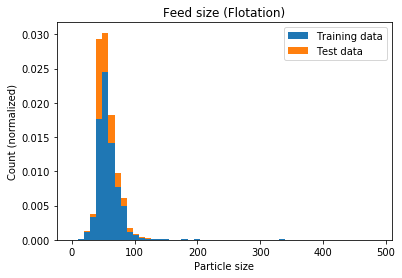

In [30]:
rougher_data = [train_df['rougher.input.feed_size'], test_df['rougher.input.feed_size']]

fig, ax = plt.subplots()
                
labels = ['Training data', 'Test data']                

ax.hist(rougher_data, bins=50, density=True, histtype='bar', stacked=True, label=labels)
ax.legend()
ax.set_title('Feed size (Flotation)')
ax.set_xlabel('Particle size')
ax.set_ylabel('Count (normalized)')

In [31]:
print(train_df['primary_cleaner.input.feed_size'].describe())
print(test_df['primary_cleaner.input.feed_size'].describe())

count    16860.000000
mean         7.297285
std          0.619166
min          1.080000
25%          6.940000
50%          7.285000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64
count    5856.000000
mean        7.264651
std         0.611526
min         5.650000
25%         6.885625
50%         7.259333
75%         7.650000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64


Text(0, 0.5, 'Count (normalized)')

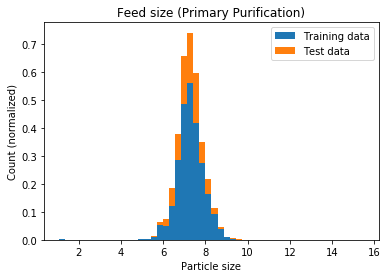

In [32]:
prim_data = [train_df['primary_cleaner.input.feed_size'], 
             test_df['primary_cleaner.input.feed_size']]

fig, ax = plt.subplots()
                
labels = ['Training data', 'Test data']                

ax.hist(prim_data, bins=50, density=True, histtype='bar', stacked=True, label=labels)
ax.legend()
ax.set_title('Feed size (Primary Purification)')
ax.set_xlabel('Particle size')
ax.set_ylabel('Count (normalized)')

I used `describe()` to compare the distributions of feed particle size of both the training and test datasets at the rougher and primary purification stages. While there was a small discrepancy in rougher feed size between the training and test data, it does not seem significant enough to address. The purification feed sizes were even closer.

**Look at total concentration of all substances at different stages**

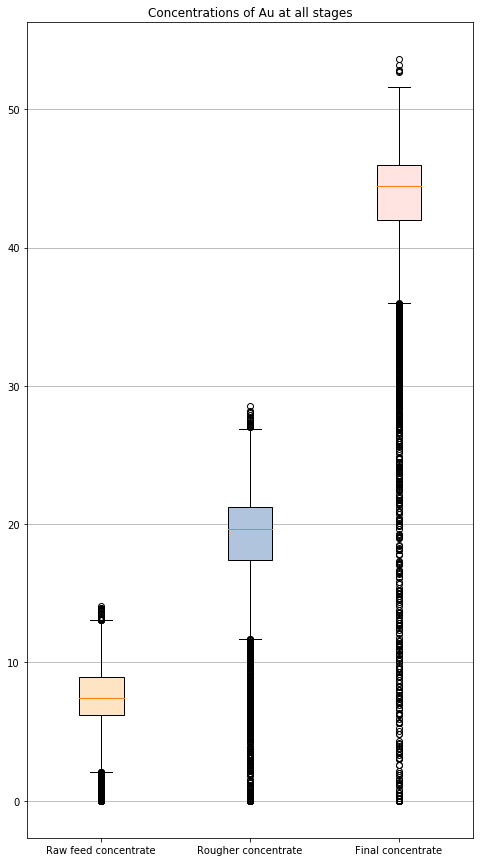

In [33]:
# Au

au_raw = train_df['rougher.input.feed_au'].values
au_rough = train_df['rougher.output.concentrate_au'].values

au_data = [au_raw, au_rough, au_final_out]

labels = ['Raw feed concentrate', 'Rougher concentrate', 'Final concentrate']

fig, ax = plt.subplots(figsize=(8,15))


bplot = ax.boxplot(au_data, vert=True, patch_artist=True, labels=labels)  
ax.set_title('Concentrations of Au at all stages')

colors = ['bisque', 'lightsteelblue', 'mistyrose']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
ax.yaxis.grid(True)
plt.show()

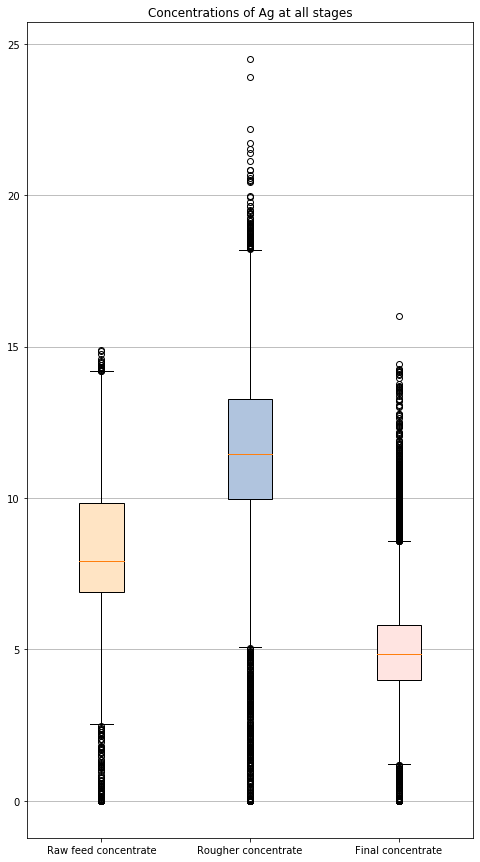

In [34]:
# Ag

ag_raw = train_df['rougher.input.feed_ag'].values
ag_rough = train_df['rougher.output.concentrate_ag'].values

ag_data = [ag_raw, ag_rough, ag_final_out]

labels = ['Raw feed concentrate', 'Rougher concentrate', 'Final concentrate']

fig, ax = plt.subplots(figsize=(8,15))


bplot = ax.boxplot(ag_data, vert=True, patch_artist=True, labels=labels)  
ax.set_title('Concentrations of Ag at all stages')

colors = ['bisque', 'lightsteelblue', 'mistyrose']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
ax.yaxis.grid(True)
plt.show()

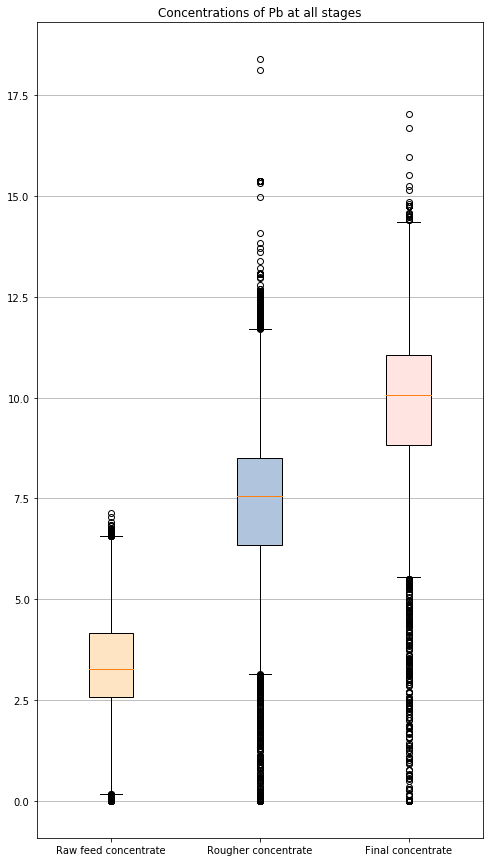

In [35]:
# Pb

pb_raw = train_df['rougher.input.feed_pb'].values
pb_rough = train_df['rougher.output.concentrate_pb'].values

pb_data = [pb_raw, pb_rough, pb_final_out]

labels = ['Raw feed concentrate', 'Rougher concentrate', 'Final concentrate']

fig, ax = plt.subplots(figsize=(8,15))


bplot = ax.boxplot(pb_data, vert=True, patch_artist=True, labels=labels)  
ax.set_title('Concentrations of Pb at all stages')

colors = ['bisque', 'lightsteelblue', 'mistyrose']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
ax.yaxis.grid(True)
plt.show()

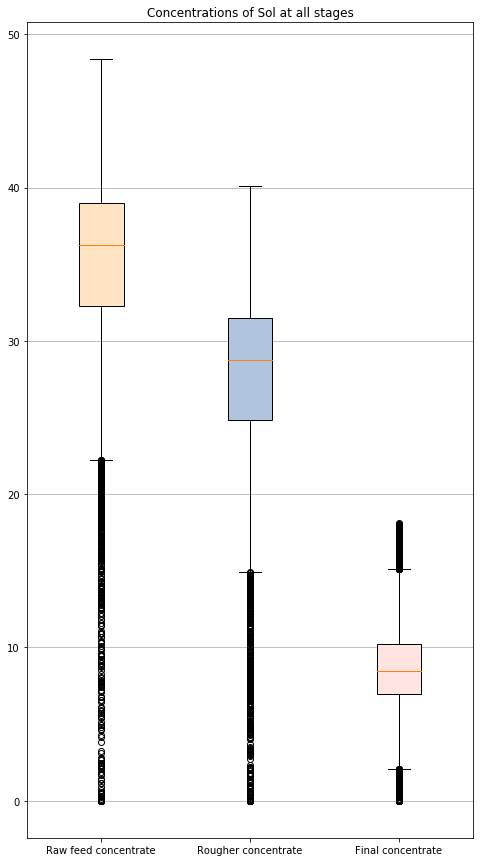

In [36]:
# Sol

sol_raw = train_df['rougher.input.feed_sol'].values
sol_rough = train_df['rougher.output.concentrate_sol'].values
sol_final_out = train_df['final.output.concentrate_sol'].values

sol_data = [sol_raw, sol_rough, sol_final_out]

labels = ['Raw feed concentrate', 'Rougher concentrate', 'Final concentrate']

fig, ax = plt.subplots(figsize=(8,15))


bplot = ax.boxplot(sol_data, vert=True, patch_artist=True, labels=labels)  
ax.set_title('Concentrations of Sol at all stages')

colors = ['bisque', 'lightsteelblue', 'mistyrose']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
ax.yaxis.grid(True)
plt.show()

I used box plots to examine the concentrations of all the substances (Au, Ag, Pb, Sol) at each stage, so I could see outlying values as well as IQRs and medians. All four substances show a huge number of outlying values near zero.

In [37]:
train_df[train_df['rougher.input.feed_au'] <= 0].head(24)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
99,2016-01-19 03:00:00,0.0,0.0,0.0,0.0,67.213166,0.0,0.0,0.0,0.0,...,13.985160,-799.601232,12.036072,-603.234250,9.974968,-497.092974,7.953962,-499.698442,11.941642,-598.541756
100,2016-01-19 04:00:00,0.0,0.0,0.0,0.0,67.213166,0.0,0.0,0.0,0.0,...,14.034374,-799.600946,12.040491,-623.446329,9.898782,-499.623262,7.979302,-500.283366,11.959950,-600.998301
101,2016-01-19 05:00:00,0.0,0.0,0.0,0.0,67.213166,0.0,0.0,0.0,0.0,...,13.943929,-799.600659,12.040238,-638.103348,9.956309,-499.791870,7.978806,-500.202026,11.987839,-600.302819
102,2016-01-19 06:00:00,0.0,0.0,0.0,0.0,67.213166,0.0,0.0,0.0,0.0,...,14.040873,-799.600372,12.030771,-641.310327,9.966952,-499.842458,8.053455,-499.588522,11.987935,-600.523057
103,2016-01-19 07:00:00,0.0,0.0,0.0,0.0,67.213166,0.0,0.0,0.0,0.0,...,13.972371,-799.600085,12.021058,-641.457227,10.033820,-501.291438,7.985956,-499.934267,12.027556,-600.108918
104,2016-01-19 08:00:00,0.0,0.0,0.0,0.0,67.213166,0.0,0.0,0.0,0.0,...,13.932580,-799.599799,12.011345,-640.936879,10.004522,-500.021534,7.931758,-500.294773,12.026439,-600.301833
105,2016-01-19 09:00:00,0.0,0.0,0.0,0.0,67.213166,0.0,0.0,0.0,0.0,...,13.989449,-799.599512,12.001631,-640.633205,9.932505,-499.399448,7.920371,-499.619457,11.997944,-600.538013
106,2016-01-19 10:00:00,0.0,0.0,0.0,0.0,67.213166,0.0,0.0,0.0,0.0,...,13.990517,-799.598096,11.991918,-643.907378,9.956062,-499.882675,8.014221,-499.688721,11.998413,-600.345361
107,2016-01-19 11:00:00,0.0,0.0,0.0,0.0,67.213166,0.0,0.0,0.0,0.0,...,13.904059,-799.591368,11.982703,-641.874749,10.016539,-498.372830,8.073042,-500.407344,11.981264,-599.271485
108,2016-01-19 12:00:00,0.0,0.0,0.0,0.0,67.213166,0.0,0.0,0.0,0.0,...,13.944915,-799.583961,11.981382,-640.686792,9.943380,-500.557792,8.037255,-500.747732,12.008122,-600.379091


A quick examination of rows in the training dataset with zero values show that they are recorded for *all* of the concentrations of the four substances at each stage. They also seem to be observations taken in succession - for example, every observation in at least one 24 hour period, as indicated above. Other features, like the final output and flotation unit parameters are recorded for these observations, but the `final.output.recovery` feature is the exact same for the entire 24 hour period shown, which is suspicious. It is possible that whatever reads and records the inputs and outputs of substances had some sort of failure, or that these were days that processing didn't happen at all (perhaps the final output values are simply the last one recorded). Regardless, they will affect the accuracy of a model, so I will remove these observations from the data.

In [38]:
train_cols = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'final.output.concentrate_au',
          'rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'final.output.concentrate_ag',
          'rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'final.output.concentrate_pb',
          'rougher.input.feed_sol', 'rougher.output.concentrate_sol', 'final.output.concentrate_sol']
for col in train_cols:
    train_df = train_df[train_df[col] > 0]

test_cols = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb',
            'rougher.input.feed_sol']
for col in test_cols:
    test_df = test_df[test_df[col] > 0]


To address the outlying zeroes, I filtered the test and train datasets for values greater than zero.

# 3. Build a model

**Function to model sMAPE value**

In [39]:
def calculate_smape(t, p):
    n = len(p)
            
    result = np.sum(2 * np.abs(t - p) / (np.abs(t) + np.abs(p))) * (100/n)
    return result

sMAPE_score = make_scorer(calculate_smape, greater_is_better=False)

**Train models, use cross-validation to evaluate**

**Rougher recovery** 

In [40]:
rougher_columns = train_df.loc[:, train_df.columns.str.contains('rougher')] 

features_train_rougher = rougher_columns.drop(['rougher.output.recovery'], axis=1)

target_train_rougher = rougher_columns['rougher.output.recovery']

In [41]:
params = {'max_depth': [1,2,3,4,5]}

dtree_cv = GridSearchCV(DecisionTreeRegressor(), params, scoring=sMAPE_score, cv=3)
dtree_cv.fit(features_train_rougher, target_train_rougher)
dtree_cv.best_params_

{'max_depth': 5}

In [42]:
dtree_cv.cv_results_['mean_test_score']

array([-7.51990351, -7.00358987, -5.78153258, -6.07292575, -4.63161011])

In [62]:
params = {'max_depth': [10], 'n_estimators': [10, 20, 30, 40, 50]}

rf_cv_rougher = GridSearchCV(RandomForestRegressor(), params, scoring=sMAPE_score, cv=3)
rf_cv_rougher.fit(features_train_rougher, target_train_rougher)
rf_cv_rougher.best_params_

{'max_depth': 10, 'n_estimators': 40}

In [64]:
rf_cv_rougher.cv_results_['mean_test_score']

array([-2.52165051, -2.36147209, -2.30308743, -2.0877422 , -2.13107802])

In [44]:
cross_val_score(
    LinearRegression(), features_train_rougher, 
    target_train_rougher, scoring=sMAPE_score, cv=3)

array([-4.25085472, -2.41602916, -4.78404641])

**Final recovery**

In [45]:
features_train_final = train_df.drop(['final.output.recovery','date'], axis=1)

target_train_final = train_df['final.output.recovery']

In [46]:
params = {'max_depth': [1,2,3,4,5]}

dtree_cv_final = GridSearchCV(DecisionTreeRegressor(), params, scoring=sMAPE_score, cv=3)
dtree_cv_final.fit(features_train_final, target_train_final)
dtree_cv_final.best_params_

{'max_depth': 4}

In [47]:
dtree_cv_final.cv_results_['mean_test_score']

array([-10.76348671,  -9.75184035,  -9.36182868,  -8.80477552,
        -8.8324515 ])

In [51]:
params = {'max_depth': [10], 'n_estimators': [10, 20, 30, 40, 50]}

rf_cv = GridSearchCV(RandomForestRegressor(), params, scoring=sMAPE_score, cv=3)
rf_cv.fit(features_train_final, target_train_final)
rf_cv.best_params_

{'max_depth': 10, 'n_estimators': 50}

In [68]:
rf_cv.cv_results_['mean_test_score']

array([-6.10835664, -5.92233784, -6.03858811, -5.87511916, -5.78369472])

In [48]:
cross_val_score(LinearRegression(), features_train_final, target_train_final, 
                scoring=sMAPE_score, cv=3)

array([-5.52696574, -3.89696735, -6.78447508])

I trained Decision Tree, Random Forest, and Linear regression models on the training data, and evaluated them using cross-validation. I determined that the Random Forest model scored the highest for the rougher recovery target, and the Linear model scored the highest for the final recovery target.

**Test models using test set**

In [96]:
full_test_match = full_df[full_df['date'].isin(test_df['date'])]
full_test_match = full_test_match[(full_test_match['rougher.output.recovery'] > 0) & 
                                 (full_test_match['final.output.recovery'] > 0)]
full_test_match = full_test_match.dropna()

rougher_features_test = full_test_match.loc[:, full_test_match.columns.str.contains('rougher')]
final_features_test = full_test_match.drop('date', axis=1)

rougher_target = full_test_match['rougher.output.recovery']
final_target = full_test_match['final.output.recovery']

In [97]:
r_feat_test_train, r_feat_test_valid, r_target_test_train, r_target_test_valid = train_test_split(
    rougher_features_test, rougher_target, test_size=.25)

f_feat_test_train, f_feat_test_valid, f_target_test_train, f_target_test_valid = train_test_split(
    final_features_test, final_target, test_size=.25)

To use the test data, I needed to find the correct target values, since they weren't in the dataset already. To do this, I matched the target values in the full dataset on the date and time the observations were collected.

In [105]:
rougher_rf_model = RandomForestRegressor(max_depth=10, n_estimators=40, random_state=12345)
rougher_rf_model.fit(r_feat_test_train, r_target_test_train)
r_predictions = rougher_rf_model.predict(r_feat_test_valid)

In [108]:
rougher_sMAPE = calculate_smape(r_target_test_valid, r_predictions)
print(rougher_sMAPE)

0.02325520868433255


In [110]:
final_lin_model = LinearRegression()
final_lin_model.fit(f_feat_test_train, f_target_test_train)
final_predictions = final_lin_model.predict(f_feat_test_valid)

In [112]:
final_sMAPE = calculate_smape(f_target_test_valid, final_predictions)
print(final_sMAPE)

2.384093542352926e-13


Finally, I tested my models on the test dataset, and calculated the sMAPE for both the rougher recovery target and the final recovery target.

**Final evaluation metrics**

In [113]:
total_sMAPE = (.25 * rougher_sMAPE) + (.75 * final_sMAPE)
print(total_sMAPE)

0.005813802171261944


# 4. Conclusion

The total sMAPE value calculated above gives an average percent error for the rougher and final outputs of each observation that is close to zero. This metric needs context in order to understand if my model's predictions are useful or not. To do so, I found a baseline to compare it against. 

In [114]:
r_target_mean = np.array([rougher_target.mean() for i in range(len(rougher_target))])
rough_baseline = calculate_smape(rougher_target, r_target_mean)
print(rough_baseline)

4.077764865703773


In [115]:
f_target_mean = np.array([final_target.mean() for i in range(len(rougher_target))])
final_baseline = calculate_smape(final_target, f_target_mean)
print(final_baseline)

7.206181494710076


In [116]:
total_mean_smape = (.25 * rough_baseline) + (.75 * final_baseline)
print(total_mean_smape)

6.424077337458501


After comparing the final sMAPE of my model to the "baseline" sMAPE (which simply used a mean value for every prediction), it seems that it is quite accurate in predicting gold output from the parameters.